# Lesson 3

So far we have only used one classification algorithm, logistic regression.
Now let's see if we can do better with a different algorithm called a "random forest".

First, let's download the data and import the libraries we'll need.

In [65]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [66]:
if not os.path.exists("utils.py"):
    !wget https://raw.githubusercontent.com/drivendataorg/tutorial-flu-shot-learning/main/utils.py

<IPython.core.display.Javascript object>

In [67]:
from utils import download_data_files

download_data_files()

<IPython.core.display.Javascript object>

And we'll read the data into pandas DataFrames.

In [68]:
labels_df = pd.read_csv("training_set_labels.csv", index_col="respondent_id")
features_df = pd.read_csv("training_set_features.csv", index_col="respondent_id")
test_features_df = pd.read_csv("test_set_features.csv", index_col="respondent_id")

<IPython.core.display.Javascript object>

Now we're ready.

In [96]:
if "google.colab" in sys.modules:
    from sklearn import set_config
    set_config(display="diagram")

<IPython.core.display.Javascript object>

## Random forest classification

A random forest is an example of an "ensemble algorithm", which means that instead of fitting one large model, it fits many small models and aggregates their results.
The small models tend to be simple, and each one is not very accurate by itself.
But combining many bad models turns out to be much more effective than you might expect.

In a random forest, the small models are decision trees (so a forest is a collection of trees -- get it?).
The simplest decision tree has a single branch, which is like an `if` statement based on a single feature.
For example, if we choose `opinion_h1n1_risk` as a feature, we could look at the fraction of people who got the H1N1 vaccine at each level of perceived risk:

In [69]:
from utils import crosstab

crosstab(labels_df["h1n1_vaccine"], features_df["opinion_h1n1_risk"])

opinion_h1n1_risk,1.0,2.0,3.0,4.0,5.0
h1n1_vaccine,,,,,
0,91.165991,83.203952,82.63205,60.789766,48.914286
1,8.834009,16.796048,17.36795,39.210234,51.085714


<IPython.core.display.Javascript object>

Based on these results, we might create a branch that checks whether `opinion_h1n1_risk` is greater than 4: if so, it predicts that the person was vaccined; otherwise it predicts they were not.
Decision trees can contain multiple branches, based on additional features.

In a random forest, each tree is based on a random subset of the training data and a random subset of the features.
So we can quickly generate a large number of different trees, each of which learns different relationships between the features and the labels.

Now suppose we have 100 trees and we want to generate a prediction. For a given person, we use each tree to make a prediction, then aggregate the predictions.
A simple way to aggregate is voting: if 70 out of 100 trees predict that a particular person was vaccinated, the predicted probability would be 70%.

Scikit-learn provides `RandomForestClassifier`, which implements a random forest algorithm.
We can use it in a `MultiOutputClassifier`, just as we did with `LogisticRegression`.

In [70]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

classifier = MultiOutputClassifier(estimator=RandomForestClassifier())

<IPython.core.display.Javascript object>

The rest of the pipeline is the same as in the previous lesson.

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("simple_imputer", SimpleImputer(strategy="mean")),
    ]
)

<IPython.core.display.Javascript object>

In [72]:
numeric_features_df = features_df.select_dtypes(include=np.number)
numeric_cols = numeric_features_df.columns

<IPython.core.display.Javascript object>

In [73]:
categoric_features_df = features_df.select_dtypes(include=np.object_)
categoric_cols = categoric_features_df.columns

<IPython.core.display.Javascript object>

In [74]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, numeric_cols),
        ("categoric", OneHotEncoder(), categoric_cols),
    ]
)

<IPython.core.display.Javascript object>

In [75]:
model6 = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", classifier),
    ]
)

<IPython.core.display.Javascript object>

Now we can fit the model with the training data.

In [76]:
model6.fit(features_df, labels_df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer())]),
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outsid...
       'household_children'],
      dtype='object')),
                                                 ('categoric', OneHotEncoder(),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

<IPython.core.display.Javascript object>

And let's see what happens when we test it with the training data (and the scoring function from the previous lesson).

In [77]:
from utils import score_model

score_model(model6, features_df, labels_df)

1.0

<IPython.core.display.Javascript object>

The model is 100% accurate!

At first this sounds like good news, but it is telling us more about the algorithm than the data.
Random forest models have a large number of coefficients; in fact, so many that they can effectively memorize the training data. So if we train and test on the same data, the accuracy seems very high.
Then if we test on a new dataset, it is usually lower.

To see how much lower, let's generate predictions on the test data and submit them on the competition site.

In [78]:
from utils import make_submission

make_submission(model6, test_features_df).to_csv("submission3.csv")

<IPython.core.display.Javascript object>

In [79]:
if "google.colab" in sys.modules:
    from google.colab import files
    files.download("submission3.csv")

<IPython.core.display.Javascript object>

The AUC score on the test data is 0.8503.
On one hand, that's better than the logistic regression model in the previous lesson, which scored 0.8355.
So we're moving up the leaderboard!

But the score on the test data is a lot less than 1.
That means that the model is overfit: it has learned details of the training data that don't apply to other datasets.

## Evaluating without peeking

At this point we have tried two algorithms and experimented with a few variations, like different kinds of regularization.
There are more algorithms we could try, and many more variations.
But as we've just seen, if we train and test a model with the same data, the score we get does not indicate how well it will do with new data.

As we test new algorithms and variations, we could generate predictions, submit them on the competition site, and compute the score on the test data.
But that would be a bad idea for several reasons, two practical and one philosophical.
The practical reasons are:

* That process is slow and hard to automate, so it would take a long time to try more than a few experiments.

* We are only allowed to submit three predictions to the competition site per day.

The philosophical reason is that every time we submit a prediction and get a score, we get some information about the true labels of the test data. As an extreme example, we could start with a random set of predictions, get a baseline score, and then change one prediction at a time. If the score goes up, that prediction was right; if the score goes down, it was wrong. With enough submissions, we could infer all of the true labels and get a perfect score.

Even if we don't abuse the system as explicitly as that, it is nevertheless true that every submission **leaks** information about the test data.
If we make too many submissions, we are likely to overfit the test data, and then the model will be less accurate with a new, unseen dataset.

So, how can we compare algorithms and tune their parameters without overfitting?
One option is to divide the training data into two **splits**, use one split to fit the model, and use the other to evaluate it.

In this framework, instead of two datasets, training and test, we have three:

* The training split, used to fit a model and find the best coefficients;

* The validation split, used to tune a model and find the best parameters;

* The test set, used to evaluate the model on unseen data.

This framework is such a common part of machine learning practice that Scikit-learn provides functions to support it, including `train_test_split`.
The following example shows how it works, dividing the features into `X_train` and `X_val`, and dividing the labels into `y_train` and `y_val`.

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
)

<IPython.core.display.Javascript object>

`test_size` specifies that the test split should have 33% of the data, which means that the training split has the other 67%.

`shuffle` indicates that the rows should be shuffled before splitting, which means that the resulting split is random.

`stratify` indicates that the splits should be stratified; that is, the distribution of labels in each split should be the same as in `labels_df`.
For example, we've seen that 21% of the respondents in the training data got the H1N1 vaccine.

In [81]:
labels_df["h1n1_vaccine"].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

<IPython.core.display.Javascript object>

If stratification was successful, the proportions should be approximately the same in the splits.
And they are.

In [82]:
y_val["h1n1_vaccine"].value_counts(normalize=True)

0    0.787611
1    0.212389
Name: h1n1_vaccine, dtype: float64

<IPython.core.display.Javascript object>

In [83]:
y_train["h1n1_vaccine"].value_counts(normalize=True)

0    0.787515
1    0.212485
Name: h1n1_vaccine, dtype: float64

<IPython.core.display.Javascript object>

Stratification is generally a good idea, especially if some labels are substantially less common than others.

Now we can fit the model with the just the training split, excluding the validation split.

In [84]:
model6.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer())]),
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outsid...
       'household_children'],
      dtype='object')),
                                                 ('categoric', OneHotEncoder(),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

<IPython.core.display.Javascript object>

Then we'll compute a score with just the validation split.

In [85]:
score_model(model6, X_val, y_val)

0.8521173299116455

<IPython.core.display.Javascript object>

If you run the split-train-validate sequence a few times, you will get different scores because the split is random and the random forest is (wait for it) also random. But you should get scores close to 0.85, which is close to the score we got from the test data on the competition site.

So it works! We can get an accurate evaluation of the model without looking at the test data.

## Tuning parameters

Now let's think about tuning the parameters of the random forest algorithm and see if we can improve the results.
Here are the parameters of `RandomForestClassifier`.

In [86]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<IPython.core.display.Javascript object>

As an example, let's experiment with `max_features`, which limits the number of features used to build each tree in the forest.
The default value is `'sqrt'`, which means that `max_features` is chosen automatically by computing the square root of the number of features.

In the input dataset, there are 36 features.

In [87]:
model6.n_features_in_

35

<IPython.core.display.Javascript object>

So the value of `max_features` is 6.

With that in mind, let's try a range of values from `4` to `14`.

In order to set the value of a parameter, we have to select `classifier` from the pipeline, then select its estimator, and assign a value to one of its parameter.
It's a little clumsy, and we'll see a better way soon, but here's what it looks like.

In [88]:
model6["classifier"].estimator.max_features = 10

<IPython.core.display.Javascript object>

Now we can loop through a sequence of values, train the model with each value of `max_features`, score the models, and save the results.

In [89]:
res = []

for max_features in range(4, 15):
    model6["classifier"].estimator.max_features = max_features
    model6.fit(X_train, y_train)
    score = score_model(model6, X_val, y_val)
    res.append((max_features, score))

<IPython.core.display.Javascript object>

Here's what the results look like.

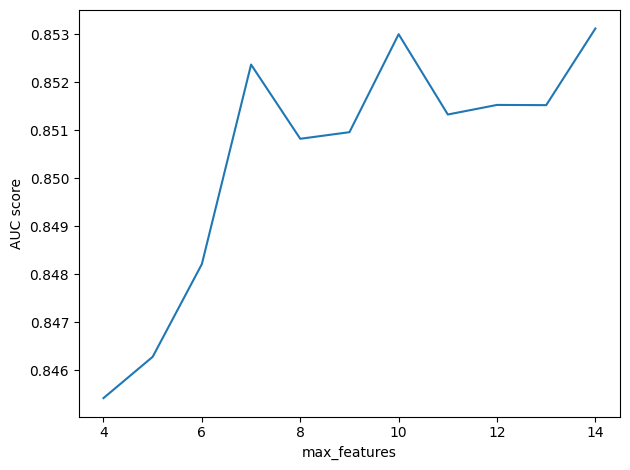

<IPython.core.display.Javascript object>

In [90]:
from utils import decorate

x, y = np.transpose(res)
plt.plot(x, y)

decorate(xlabel="max_features", ylabel="AUC score")

It looks like larger values of `max_features` are better, but the results are random, so if you run this test a few times, you'll see that the results vary and the best value might be different from one run to the next.

We can get more reliable results using cross validation, which is the topic of the next section.

## Cross-validation

Instead of using one random split, an alternative is to use multiple non-random splits.
One way to do that is $k$-fold cross-validation, where $k$ is the number of splits. 
With `k=5`, which is a common choice, it works like this:

1. Divide the training data into 5 equal-sized parts, called **folds**.

2. Train the model using all folds except the first, then use the first fold to validate.

3. Train the model using all folds except the second, then use the second fold to validate.

4. Repeat for the other three folds.

5. Compute the mean of the 5 validation scores.

As you might expect by now, Scikit-learn provides a function that automates this process.
Here's how it works.

In [91]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model6, features_df, labels_df, cv=5, scoring=score_model)

<IPython.core.display.Javascript object>

The arguments are the model, the training features, and the training labels.
The parameter `cv=5` indicates 5-fold cross-validation.
And `scoring` indicates the function that should be used to compute the scores.

In [92]:
scores

array([0.85476715, 0.85290285, 0.85738744, 0.86328533, 0.85323255])

<IPython.core.display.Javascript object>

Now let's try again to find the best value of `max_features`.
The following loop tests a range of values and uses 5-fold cross-validation for each.
It might take a little while to run!

In [93]:
res_cv = []

for max_features in range(4, 15):
    print(max_features)
    model6["classifier"].estimator.max_features = max_features
    scores = cross_val_score(model6, features_df, labels_df, cv=5, scoring=score_model)
    res_cv.append((max_features, scores))

4
5
6
7
8
9
10
11
12
13
14


<IPython.core.display.Javascript object>

Here's what the results look like. The `x` markers show the results from each of the five folds. The `o` markers show the average score for each value of `max_features`.

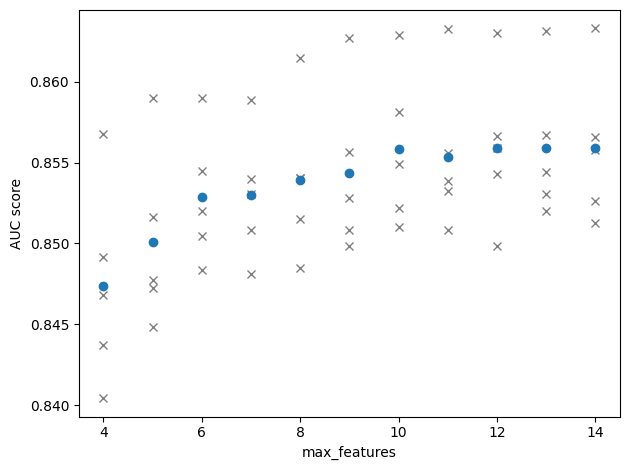

<IPython.core.display.Javascript object>

In [94]:
for x, ys in res_cv:
    plt.plot([x] * 5, ys, "x", color="gray")
    plt.plot(x, ys.mean(), "o", color="C0")

decorate(xlabel="max_features", ylabel="AUC score")

It looks like the larger values of `max_features` are better than the lower values, but above 8 or 9 the difference is small and the results are highly variable.
However, if the value computed by `sqrt` is 6, it seems like we could do better by increasing it.

## Grid search

What we did in the previous section is called a **grid search**, because we searched for the best value of a parameter by trying a sequence of equally-spaced values that form a one-dimensional grid.
This kind of search is so common that Scikit-learn provides a function, called `GridSearchCV`, that does it automatically.
The `CV` part of the name stands for "cross-validation".

To use it, we have to specify which parameters we want to vary and which values to try.
It's possible to try different combinations of multiple variables, but let's start with just one, `n_estimators`, which indicates the number of trees in the forest.

The way we'll specify the grid is a dictionary that maps from each parameter to a sequence of values.

In [97]:
param_grid = {
    "classifier__estimator__n_estimators": [100, 200, 400, 800],
}

<IPython.core.display.Javascript object>

The way we specify the name of the parameter is a bit of a hack.
Remember that previously we used a statement like this to select the classifier from the pipeline, select the estimator, and then set the parameter:

In [98]:
model6["classifier"].estimator.max_features = 12

<IPython.core.display.Javascript object>

Now we need a way to tell `GridSearchCV` how to do the same thing.
The people who wrote this function solved the problem with some ad hoc syntax: using double underscores to separate the names of the elements.

Now we can run the search like this:

In [99]:
from sklearn.model_selection import GridSearchCV

searcher = GridSearchCV(
    estimator=model6,
    param_grid=param_grid,
    scoring=score_model,
    cv=5,
    n_jobs=-1,
    verbose=1,
)

<IPython.core.display.Javascript object>

`estimator` indicates the model we want to fit.
`params` is the dictionary of parameters we want to search.
`scoring_model` and `cv` are passed along to `cross_val_score`.

`n_jobs` suggests how many jobs to run in parallel; the value `-1` indicates that the number of jobs should be the same as the number of available processors. 

In [100]:
%time searcher.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 20.3 s, sys: 404 ms, total: 20.7 s
Wall time: 52.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('standard_scaler',
                                                                                          StandardScaler()),
                                                                                         ('simple_imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_ga...
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                                       ('classifier',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(max_features=12)))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__n_estimators': [100, 200, 400,
                                                                 800]},
             scoring=<function score_model at 0x7f019506a4d0>, verbose=1)

<IPython.core.display.Javascript object>

From the `GridSearchCV` object, we can extract `best_params_`, which contains the values of the parameters that yielded the best results.

In [101]:
searcher.best_params_

{'classifier__estimator__n_estimators': 800}

<IPython.core.display.Javascript object>

We get the best score with 800 trees, which is the largest value we tried. So it might be a good idea to go back and test larger values.

`best_score_` contains the best score, which is the average of the 5 folds.

In [102]:
searcher.best_score_

0.8591970580076123

<IPython.core.display.Javascript object>

We can also extract the model with the parameters that were found to be the best.

In [103]:
best_model = searcher.best_estimator_
best_model["classifier"].estimator

RandomForestClassifier(max_features=12, n_estimators=800)

<IPython.core.display.Javascript object>

And use it to generate predictions.

In [104]:
make_submission(best_model, test_features_df).to_csv("submission4.csv")

<IPython.core.display.Javascript object>

In [105]:
if "google.colab" in sys.modules:
    from google.colab import files
    files.download("submission4.csv")

<IPython.core.display.Javascript object>

When I submitted these predictions on the competition site, the score was 0.8529, which is a little less than `best_score_`.
Some part of the difference is due to overfitting, as we've discussed.
Another part is due to a kind of [regression toward the mean](https://en.wikipedia.org/wiki/Regression_toward_the_mean).
The best model in a grid search is generally good, but that's not all; in order to come out on top in a grid search, it also has to be lucky.
Good parameters are always good, but luck is random, so we expect the result of a grid search to be a little less lucky on the test data.

**Exercise:** Run a grid search on one of the other parameters and see if you can do any better.
Optionally, pick two parameters and run a two-dimensional search.

Notice that with even a small number of parameters, and a few possible values for each, the number of combinations grows very quickly. Trying all of them is usually impractical, and it is not always time well spent. The more combinations you try, the more likely you are to find a combination that works well on the training data and less well on the test data.
Excessive optimization of parameters is yet another way to overfit a model.

In [106]:
# Solution

model6["classifier"].estimator.max_features = 12
model6["classifier"].estimator.n_estimators = 400

<IPython.core.display.Javascript object>

In [107]:
# Solution

params = {
    "classifier__estimator__max_leaf_nodes": [10, 20, 30],
    "classifier__estimator__max_depth": [10, 20, 30],
}

<IPython.core.display.Javascript object>

In [108]:
# Solution

searcher = GridSearchCV(
    estimator=model6,
    param_grid=params,
    scoring=score_model,
    cv=5,
    n_jobs=-1,
    verbose=1,
)

<IPython.core.display.Javascript object>

In [109]:
# Solution

%time searcher.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: user 4.9 s, sys: 88 ms, total: 4.98 s
Wall time: 34.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('standard_scaler',
                                                                                          StandardScaler()),
                                                                                         ('simple_imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_ga...
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                                       ('classifier',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(max_features=12,
                                                                                               n_estimators=400)))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__max_depth': [10, 20, 30],
                         'classifier__estimator__max_leaf_nodes': [10, 20, 30]},
             scoring=<function score_model at 0x7f019506a4d0>, verbose=1)

<IPython.core.display.Javascript object>

In [110]:
# Solution

searcher.best_params_

{'classifier__estimator__max_depth': 30,
 'classifier__estimator__max_leaf_nodes': 30}

<IPython.core.display.Javascript object>

In [111]:
# Solution

searcher.best_score_

0.8492685602887402

<IPython.core.display.Javascript object>

In [112]:
# Solution

best_model = searcher.best_estimator_
best_model["classifier"].estimator

RandomForestClassifier(max_depth=30, max_features=12, max_leaf_nodes=30,
                       n_estimators=400)

<IPython.core.display.Javascript object>

## Gradient boosting

Random forest classifiers are generally pretty good, but in the last decade they have been overshadowed by the success of [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting).
Compared to random forests, algorithms using gradient boosting tend to be faster and more accurate.

Gradient boosting is based on two ideas:

* Instead of fitting many simple models to the same data, we fit a sequence of models where each model tries to correct the errors of the previous model, which is called **boosting**, and

* At each stage, we choose the best model by minimizing a "cost" that quantifies the magnitude of the errors. This minimization can be done efficiently using **gradient descent** algorithms.

So gradient boosting might be more explicitly called "boosting using gradient descent".

Scikit-learn provides several classification algorithms based on gradient boosting, including `AdaBoostClassifier` and `GradientBoostingClassifier`, but the one that's recommended for datasets with more than 10,000 rows (like ours) is `HistGradientBoostingClassifier`.

One feature of this classifier is that it can handle missing data, so the preprocessing pipeline can be simple. For the numerical variables, we don't have to do anything! For the categorical variables, we'll use the ordinal encoder.

In [114]:
from sklearn.preprocessing import OrdinalEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", "passthrough", numeric_cols),
        ("categoric", OrdinalEncoder(), categoric_cols),
    ]
)

<IPython.core.display.Javascript object>

Now, when we make the `HistGradientBoostingClassifier`, we have to tell it which variables are categoric, which we'll do by providing their indices in the list of features.

In [115]:
categoric_indices = [features_df.columns.get_loc(col) for col in categoric_cols]
categoric_indices

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34]

<IPython.core.display.Javascript object>

In [116]:
from sklearn.ensemble import HistGradientBoostingClassifier

classifier = MultiOutputClassifier(
    estimator=HistGradientBoostingClassifier(
        categorical_features=categoric_indices,
    )
)

<IPython.core.display.Javascript object>

Here's the complete model.

In [117]:
model7 = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", classifier),
    ]
)

<IPython.core.display.Javascript object>

And we can fit it as usual.

In [118]:
model7.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'c...
                                                 ('categoric', OrdinalEncoder(),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                ('classifier',
                 MultiOutputClassifier(estimator=HistGradientBoostingClassifier(categorical_features=[21,
                                                                                                      22,
                                                                                                      23,
                                                                                                      24,
                                                                                                      25,
                                                                                                      26,
                                                                                                      27,
                                                                                                      28,
                                                                                                      29,
                                                                                                      30,
                                                                                                      33,
                                                                                                      34])))])

<IPython.core.display.Javascript object>

It takes less time to train than the previous classifiers.
And it gets a better score, too.

In [119]:
score_model(model7, X_val, y_val)

0.8583874615357423

<IPython.core.display.Javascript object>

**Exercise:** Use cross-validation to get a better sense of how well this classifier works.

In [120]:
# Solution

scores = cross_val_score(model7, features_df, labels_df, cv=5, scoring=score_model)
scores.mean()

0.864181362238879

<IPython.core.display.Javascript object>

**Exercise:** Choose one of the parameters and use a grid search to tune it.
[This article](https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/) might give you some ideas for which parameters would be good choices.

Use the best model you find to generate predictions and submit them to the platform.

In [121]:
model7["classifier"].estimator.get_params()

{'categorical_features': [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34],
 'early_stopping': 'auto',
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

<IPython.core.display.Javascript object>

In [122]:
# Solution

# As an example, I chose to search the learning rate, but you should try other parameters,
# maybe more than one.

params = {
    "classifier__estimator__learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
}

<IPython.core.display.Javascript object>

In [123]:
# Solution

from sklearn.model_selection import GridSearchCV

searcher = GridSearchCV(
    estimator=model7,
    param_grid=params,
    scoring=score_model,
    cv=5,
    n_jobs=-1,
    verbose=1,
)

<IPython.core.display.Javascript object>

In [124]:
# Solution

%time searcher.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 11.1 s, sys: 30.7 ms, total: 11.1 s
Wall time: 5.08 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n...
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                                       ('classifier',
                                        MultiOutputClassifier(estimator=HistGradientBoostingClassifier(categorical_features=[21,
                                                                                                                             22,
                                                                                                                             23,
                                                                                                                             24,
                                                                                                                             25,
                                                                                                                             26,
                                                                                                                             27,
                                                                                                                             28,
                                                                                                                             29,
                                                                                                                             30,
                                                                                                                             33,
                                                                                                                             34])))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__learning_rate': [0.01, 0.03,
                                                                  0.05, 0.07,
                                                                  0.1]},
             scoring=<function score_model at 0x7f019506a4d0>, verbose=1)

<IPython.core.display.Javascript object>

In [125]:
# Solution

searcher.best_params_

{'classifier__estimator__learning_rate': 0.05}

<IPython.core.display.Javascript object>

In [126]:
# Solution

searcher.best_score_

0.8643247987814199

<IPython.core.display.Javascript object>

In [127]:
# Solution

best_model = searcher.best_estimator_
best_model["classifier"].estimator

HistGradientBoostingClassifier(categorical_features=[21, 22, 23, 24, 25, 26, 27,
                                                     28, 29, 30, 33, 34],
                               learning_rate=0.05)

<IPython.core.display.Javascript object>

In [128]:
# Solution

make_submission(best_model, test_features_df).to_csv("submission5.csv")

<IPython.core.display.Javascript object>

## Vocabulary

The vocabulary in this tutorial is meant to be consistent with the Scikit-learn documentation, but some of the terms we've defined are used differently in other contexts.

For example, we presented the train-validate-test framework like this:

* The training split is used to fit a model and find the best coefficients;

* The validation split is used to tune a model and find the best parameters; and

* The test data is used to evaluate the model on unseen data.

But the things we called coefficients are sometimes called parameters; when they are, the things we called parameters are called **hyperparameters**.

Also, the names we used for the splits are not universal. What we called the test set is sometimes called the **holdout set** because it is held out from the model during training. And you might see ["validation" and "test"](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets#Confusion_in_terminology) used differently as well.

The inconsistency of these terms can be a source of confusion when you use the Scikit-learn function called `train_test_split`, because it is not only used to split the training and test data; it is also used to split the training and validation data.
In this tutorial, the train-test split test was done for us by the people who set up the competition; then we divided the training data we were given, further, into a training split and a validation split.

In an attempt to avoid confusion, we used "training data" for all of the data we got and "training split" for the part we split off from the validation split.
But you are likely to see these terms used interchangeably.


We have you have found this tutorial useful. In the near future, we are planning to develop additional tutorials that work with different kinds of data, including images, text, and maybe videos.